In [1]:
pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.4 MB/s eta 0:00:00


In [2]:
import math, time, re
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from dtaidistance import dtw
import matplotlib.pyplot as plt

In [3]:
BASE_DIR=Path("/content/drive/MyDrive/Dance_clean_data")

In [4]:
SEQ_IN,SEQ_OUT=30,30
BATCH=128
EPOCHS=10
LR=1e-3
WDECAY=0.0
HIDDEN=128
LAYERS=2
VEL_W=0.10
GRAD_CLIP=1.0
WINDOW_STRIDE_EVAL=10
MAX_EVAL_WINDOWS=20000
MAX_DTW_SAMPLES=64

In [5]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP=torch.cuda.is_available()
torch.backends.cudnn.benchmark=True
try: torch.set_float32_matmul_precision('high')
except: pass

In [6]:
def dancer_from_path(p: Path):
    m=re.match(r"^(D\d+)",p.parent.name)
    return m.group(1) if m else p.parent.name

def load_npy_by_pattern(base_dir: Path,ps: str,edim=None):
    b={}
    for f in base_dir.rglob("*.npy"):
        if ps.lower() not in f.name.lower():
            continue
        arr=np.load(f)
        if arr.ndim!=2:
            continue
        if edim is not None and arr.shape[1]!=edim:
            continue
        d=dancer_from_path(f)
        b.setdefault(d, []).append(arr.astype(np.float32))
    return b

def vstack_or_empty(la,D=None):
    if not la:
        return np.empty((0, D if D is not None else 0),np.float32)
    return np.vstack(la).astype(np.float32)


In [7]:
def build_io(data_2d,in_len=30,out_len=30,feat_dim=None,stride=1):
    T=len(data_2d)
    if feat_dim is None: feat_dim=data_2d.shape[1] if data_2d.ndim==2 else 0
    if T<in_len+out_len:
        return (np.empty((0,in_len,feat_dim),np.float32),
                np.empty((0,out_len,feat_dim),np.float32))
    X,Y=[],[]
    for i in range(0,T-in_len-out_len+1,stride):
        X.append(data_2d[i:i+in_len])
        Y.append(data_2d[i+in_len:i+in_len+out_len])
    return np.stack(X).astype(np.float32),np.stack(Y).astype(np.float32)

In [8]:
def fit_scaler(X_windows):
    sc=StandardScaler().fit(X_windows.reshape(-1, X_windows.shape[-1]))
    mu,sig=sc.mean_.astype(np.float32),sc.scale_.astype(np.float32)
    sig[sig==0]=1.0
    return mu, sig

def transform_safe(x,mu,sig): return (x - mu)/sig
def inv_transform_safe(x, mu, sig): return x*sig+mu

def velocity(x):
    return x[:,1:,:]-x[:,:-1,:]

In [9]:
train_by_d=load_npy_by_pattern(BASE_DIR,"train")
zig_by_d=load_npy_by_pattern(BASE_DIR,"zigzag")
circ_by_d=load_npy_by_pattern(BASE_DIR,"circle")

def concat_all(b):
    if not b: return np.empty((0,0),np.float32)
    any_d=next(iter(b))
    Ddim=b[any_d][0].shape[1]
    return vstack_or_empty([arr for d in b for arr in b[d]],D=Ddim)

train_all=concat_all(train_by_d)
zig_all=concat_all(zig_by_d)
circ_all=concat_all(circ_by_d)

print("Shapes–train:",train_all.shape, " zig:", zig_all.shape, " circle:",circ_all.shape)
if train_all.size==0: raise RuntimeError("No 'train' .npy found.")
D=train_all.shape[1]

Shapes–train: (331508, 112)  zig: (132034, 112)  circle: (138524, 112)


In [10]:
Xtr_raw,Ytr_raw=build_io(train_all,SEQ_IN,SEQ_OUT,feat_dim=D,stride=1)
print("Train window:",Xtr_raw.shape,Ytr_raw.shape)
n=len(Xtr_raw); n_val=max(int(0.1*n),1)
Xtr_raw,Ytr_raw,Xval_raw,Yval_raw=Xtr_raw[:-n_val],Ytr_raw[:-n_val],Xtr_raw[-n_val:],Ytr_raw[-n_val:]
print(f"Split-Train: {len(Xtr_raw)}  Val: {len(Xval_raw)}")

mu,sig=fit_scaler(Xtr_raw)
Xtr=transform_safe(Xtr_raw,mu,sig);  Ytr=transform_safe(Ytr_raw,mu,sig)
Xval=transform_safe(Xval_raw,mu,sig); Yval=transform_safe(Yval_raw,mu,sig)

ctx_last_tr=Xtr[:,-1,:]
ctx_last_val=Xval[:,-1,:]
Ytr_resid=Ytr-ctx_last_tr[:,None,:]
Yval_resid=Yval-ctx_last_val[:,None,:]


Train window: (331449, 30, 112) (331449, 30, 112)
Split-Train: 298305  Val: 33144


In [11]:
class Encoder(nn.Module):
    def __init__(self,input_dim,hidden_dim=HIDDEN,num_layers=LAYERS):
        super().__init__()
        self.lstm=nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
    def forward(self, x):
        _, (h, c)=self.lstm(x)
        return h,c

In [12]:
class Decoder(nn.Module):
    def __init__(self,input_dim,hidden_dim=HIDDEN,output_dim=None,num_layers=LAYERS):
        super().__init__()
        self.lstm=nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)
        self.fc=nn.Linear(hidden_dim,input_dim if output_dim is None else output_dim)
    def forward(self, x, h, c):
        y,(h,c)=self.lstm(x,(h,c))
        out=self.fc(y)
        return out,h,c

In [13]:
class Seq2Seq(nn.Module):
    def __init__(self,input_dim,hidden_dim=HIDDEN,layers=LAYERS,out_len=SEQ_OUT):
        super().__init__()
        self.out_len=out_len
        self.enc=Encoder(input_dim,hidden_dim,layers)
        self.dec=Decoder(input_dim,hidden_dim,input_dim,layers)

    def forward_train(self,src,tgt_abs):
        h,c=self.enc(src)
        last_ctx=src[:, -1:, :]
        dec_in=torch.cat([last_ctx, tgt_abs[:, :-1, :]], dim=1)
        y, _=self.dec.lstm(dec_in, (h, c))
        out=self.dec.fc(y)
        tgt_resid=tgt_abs-last_ctx
        return out,tgt_resid

    @torch.no_grad()
    def forward_eval(self, src):
        h,c=self.enc(src)
        last_ctx=src[:,-1:,:]
        dec_in=last_ctx.clone()
        outs_resid=[]
        for _ in range(self.out_len):
            y,(h,c)=self.dec.lstm(dec_in,(h,c))
            resid=self.dec.fc(y)
            outs_resid.append(resid)
            dec_in=last_ctx+resid
        resid_cat=torch.cat(outs_resid,dim=1)
        abs_cat=last_ctx+resid_cat
        return abs_cat

In [14]:
def train_seq2seq(X_tr,Y_tr_abs,X_val,Y_val_abs,d_feat):
    model=Seq2Seq(d_feat).to(DEVICE)
    opt=torch.optim.AdamW(model.parameters(),lr=LR,weight_decay=WDECAY)
    loss_pos=nn.SmoothL1Loss()
    scaler=torch.amp.GradScaler("cuda",enabled=AMP)

    train_loader=DataLoader(TensorDataset(torch.tensor(X_tr),torch.tensor(Y_tr_abs)),batch_size=BATCH,shuffle=True,drop_last=True,
        num_workers=4,pin_memory=True,persistent_workers=True)

    val_loader=DataLoader(TensorDataset(torch.tensor(X_val),torch.tensor(Y_val_abs)),batch_size=BATCH,shuffle=False,drop_last=False,
        num_workers=4,pin_memory=True, persistent_workers=True)

    def vel(x):return x[:,1:,:]-x[:,:-1,:]

    print("\nTraining:")
    for ep in range(1,EPOCHS+1):
        model.train(); tot=0.0; t0=time.time()
        for xb,yb_abs in train_loader:
            xb=xb.to(DEVICE,non_blocking=True)
            yb_abs=yb_abs.to(DEVICE,non_blocking=True)
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda",enabled=AMP):
                pred_resid,tgt_resid=model.forward_train(xb,yb_abs)
                loss=loss_pos(pred_resid,tgt_resid)+VEL_W*loss_pos(vel(pred_resid),vel(tgt_resid))
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(),GRAD_CLIP)
            scaler.step(opt);scaler.update()
            tot+=loss.item()

        model.eval();vtot=0.0
        with torch.no_grad(),torch.amp.autocast("cuda",enabled=AMP):
            for xb,yb_abs in val_loader:
                xb=xb.to(DEVICE,non_blocking=True)
                yb_abs=yb_abs.to(DEVICE,non_blocking=True)
                pred_abs=model.forward_eval(xb)
                vtot+=(loss_pos(pred_abs, yb_abs)+VEL_W*loss_pos(vel(pred_abs),vel(yb_abs))).item()

        print(f"Epoch {ep:02d} | Train: {tot/len(train_loader):.5f}  Val: {vtot/len(val_loader):.5f}")
    return model

In [15]:
def evaluate(model,X_abs,Y_abs,name="",max_dtw=MAX_DTW_SAMPLES):
    if len(X_abs)==0:
        print(f"{name}: 0 windows.");return None
    Xt=torch.tensor(X_abs,dtype=torch.float32,device=DEVICE)
    with torch.amp.autocast("cuda",enabled=AMP):
        pred_abs=model.forward_eval(Xt).cpu().numpy()
    gt=Y_abs
    l1=float(np.mean(np.abs(pred_abs-gt)))
    l2=float(np.mean((pred_abs-gt)**2))
    k=min(len(gt),max_dtw)
    dvals=[dtw.distance(pred_abs[i].reshape(-1),gt[i].reshape(-1)) for i in range(k)]
    print(f"{name}: L1={l1:.4f}  L2={l2:.4f}  DTW={np.mean(dvals):.4f}")
    return {"l1": l1, "l2": l2, "dtw": float(np.mean(dvals))}

In [16]:
def windows_eval(long_arr,mu,sig,d_feat,name):
    Xr,Yr=build_io(long_arr,SEQ_IN,SEQ_OUT,feat_dim=d_feat,stride=WINDOW_STRIDE_EVAL)
    if Xr.size==0:
        #print(f"[eval-build] {name}: 0 windows")
        return (np.empty((0,SEQ_IN,d_feat),np.float32),np.empty((0,SEQ_OUT,d_feat),np.float32))
    if len(Xr)>MAX_EVAL_WINDOWS:
        idx=np.linspace(0,len(Xr)-1,num=MAX_EVAL_WINDOWS,dtype=int)
        Xr,Yr=Xr[idx],Yr[idx]
    Xs=transform_safe(Xr,mu,sig); Ys=transform_safe(Yr,mu,sig)
    #print(f"[eval-build] {name}: {Xs.shape} windows (stride={WINDOW_STRIDE_EVAL}, cap={MAX_EVAL_WINDOWS})")
    return Xs,Ys

In [17]:
model_all=train_seq2seq(Xtr,Ytr,Xval,Yval,d_feat=D)

Xs_tr,Ys_tr=windows_eval(train_all,mu,sig,D,"S2S->Train(All)")
Xs_zig,Ys_zig=windows_eval(zig_all,mu,sig,D,"S2S->Zigzag(All)")
Xs_cir,Ys_cir=windows_eval(circ_all,mu,sig,D,"S2S->Circle(All)")

evaluate(model_all,Xs_tr,Ys_tr,name="Seq2Seq–Train(All)")
evaluate(model_all,Xs_zig,Ys_zig,name="Seq2Seq–Zigzag(All)")
evaluate(model_all,Xs_cir,Ys_cir,name="Seq2Seq–Circle(All)")



Training:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | Train: 0.00395  Val: 0.01312
Epoch 02 | Train: 0.00158  Val: 0.01486
Epoch 03 | Train: 0.00120  Val: 0.01510
Epoch 04 | Train: 0.00101  Val: 0.02038
Epoch 05 | Train: 0.00091  Val: 0.01907
Epoch 06 | Train: 0.00083  Val: 0.02129
Epoch 07 | Train: 0.00078  Val: 0.02472
Epoch 08 | Train: 0.00073  Val: 0.02550
Epoch 09 | Train: 0.00070  Val: 0.02789
Epoch 10 | Train: 0.00067  Val: 0.02969
Seq2Seq–Train(All): L1=0.0744  L2=0.0611  DTW=8.3372
Seq2Seq–Zigzag(All): L1=0.1464  L2=0.1211  DTW=6.4559
Seq2Seq–Circle(All): L1=0.1433  L2=0.0913  DTW=15.2507


{'l1': 0.14326044917106628,
 'l2': 0.0913141742348671,
 'dtw': 15.250679081955136}

In [18]:
@torch.no_grad()
def predict_full_file_seq2seq(arr,model,mu,sig,seq_in=SEQ_IN,seq_out=SEQ_OUT,step=1,batch_size=256,device=DEVICE,amp=AMP):
    model.eval()
    T,D=arr.shape
    if T<=seq_in:
        raise ValueError("File too short to predict:T=seq_in")

    mu_=mu.astype(np.float32)
    sig_=sig.astype(np.float32).copy()
    sig_[sig_==0]=1.0
    Xs=(arr-mu_)/sig_
    starts=list(range(0,T-seq_in,step))
    pred_sum=np.zeros((T, D),dtype=np.float32)
    pred_count=np.zeros((T,),dtype=np.int32)

    for b in range(0,len(starts),batch_size):
        c=starts[b:b+batch_size]
        if not c:
            break
        ctx_batch=np.stack([Xs[s:s+seq_in] for s in c],axis=0)
        xb=torch.tensor(ctx_batch,dtype=torch.float32,device=device)

        with torch.amp.autocast("cuda",enabled=amp):
            pred_norm_abs=model.forward_eval(xb)
        pred_np=pred_norm_abs.detach().cpu().numpy()

        for i,s in enumerate(c):
            for k in range(seq_out):
                t=s+seq_in+k
                if t>=T:
                    break
                pred_sum[t]+=pred_np[i,k]
                pred_count[t]+=1

    v=pred_count>0
    pred_full_norm=np.zeros_like(arr,dtype=np.float32)
    den=np.maximum(pred_count[v].astype(np.float32)[:, None],1.0)
    pred_full_norm[v]=pred_sum[v]/den
    pred_full=pred_full_norm*sig_+mu_
    pred_full[:seq_in]=arr[:seq_in]
    return pred_full,v


In [19]:
def _prep_xyz(gt_T,pred,xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30):
    xi,yi,zi=xyz_idx
    T=gt_T.shape[0]
    gt_xyz=gt_T[:, [xi,yi,zi]].astype(np.float32)
    pred_xyz=pred[:, [xi, yi, zi]].astype(np.float32)
    if normalize_to_last_context and T>ctx_len:
        origin=gt_xyz[ctx_len-1].copy()
        gt_xyz=gt_xyz-origin
        pred_xyz=pred_xyz-origin
        ctx_pt=np.zeros(3, np.float32); suffix=" (normalized to last context)"
    else:
        ctx_pt=gt_xyz[min(ctx_len-1,T-1)];suffix=""
    return gt_xyz,pred_xyz,ctx_pt,suffix

In [20]:
def plot_3d(gt_T,pred,title="file",xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30,figsize=(12,9)):
    gt_xyz,pred_xyz,ctx_pt,suffix=_prep_xyz(gt_T, pred, xyz_idx,normalize_to_last_context,ctx_len)
    fig=plt.figure(figsize=figsize); ax=fig.add_subplot(111, projection='3d')
    ax.plot(gt_xyz[ctx_len:,0],gt_xyz[ctx_len:,1],gt_xyz[ctx_len:,2],'--', lw=2,label='GT')
    ax.plot(pred_xyz[ctx_len:,0],pred_xyz[ctx_len:,1],pred_xyz[ctx_len:,2],'-',lw=2,label='Pred')
    ax.scatter(ctx_pt[0],ctx_pt[1],ctx_pt[2],s=60,c='k',label='context end')
    ax.set_title(title + suffix); ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z'); ax.legend()
    try:
        mins=np.minimum(gt_xyz.min(0),pred_xyz.min(0)); maxs=np.maximum(gt_xyz.max(0),pred_xyz.max(0))
        ax.set_box_aspect((maxs-mins))
    except Exception: pass
    plt.tight_layout(); plt.show()

In [21]:
def plot_2d(gt_T, pred,title="file",xyz_idx=(0,1,2),normalize_to_last_context=True,ctx_len=30,figsize=(16,5)):
    gt_xyz,pred_xyz,ctx_pt,suffix=_prep_xyz(gt_T,pred,xyz_idx,normalize_to_last_context,ctx_len)
    fig,axes=plt.subplots(1,3,figsize=figsize)
    (ax_xy,ax_xz,ax_yz)=axes
    ax_xy.plot(gt_xyz[ctx_len:,0],gt_xyz[ctx_len:,1],'--',lw=2,label='GT')
    ax_xy.plot(pred_xyz[ctx_len:,0],pred_xyz[ctx_len:,1],'-',lw=2,label='Pred')
    ax_xy.scatter(ctx_pt[0],ctx_pt[1],c='k',marker='x',s=50);ax_xy.set_title(f"{title} – X–Y{suffix}"); ax_xy.legend()

    ax_xz.plot(gt_xyz[ctx_len:,0],gt_xyz[ctx_len:,2],'--',lw=2,label='GT')
    ax_xz.plot(pred_xyz[ctx_len:,0],pred_xyz[ctx_len:,2],'-',lw=2,label='Pred')
    ax_xz.scatter(ctx_pt[0],ctx_pt[2],c='k',marker='x',s=50); ax_xz.set_title("X–Z"); ax_xz.legend()

    ax_yz.plot(gt_xyz[ctx_len:,1],gt_xyz[ctx_len:,2],'--',lw=2,label='GT')
    ax_yz.plot(pred_xyz[ctx_len:,1],pred_xyz[ctx_len:,2],'-',lw=2,label='Pred')
    ax_yz.scatter(ctx_pt[1],ctx_pt[2],c='k',marker='x', s=50);ax_yz.set_title("Y–Z"); ax_yz.legend()
    for ax in axes: ax.grid(True, alpha=0.2)
    plt.tight_layout(); plt.show()

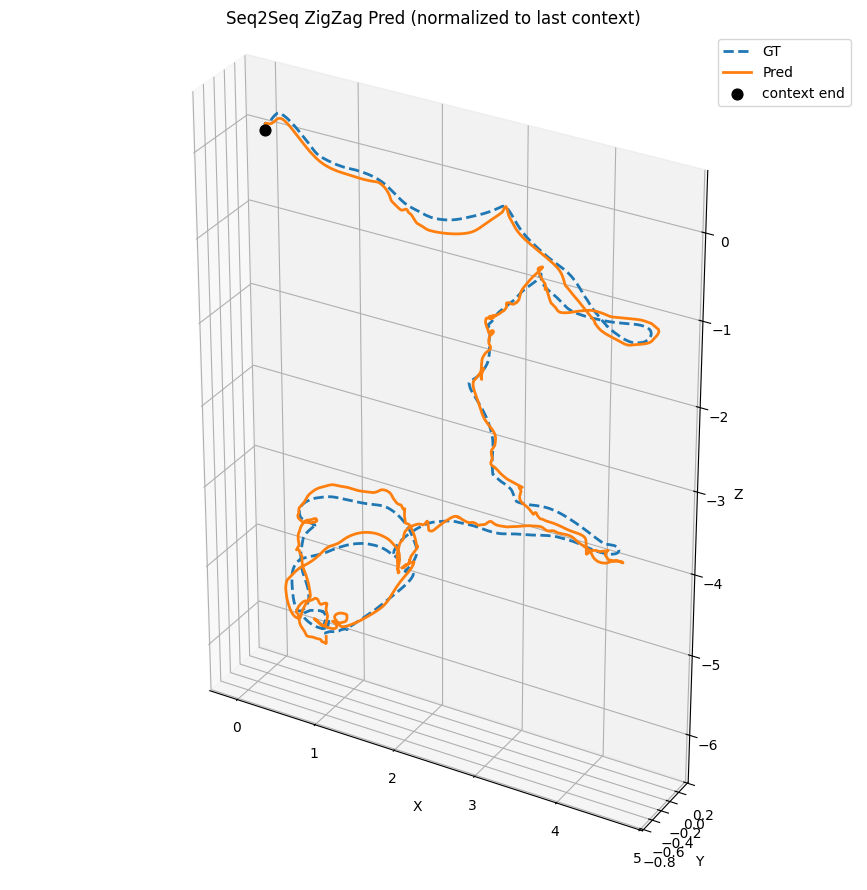

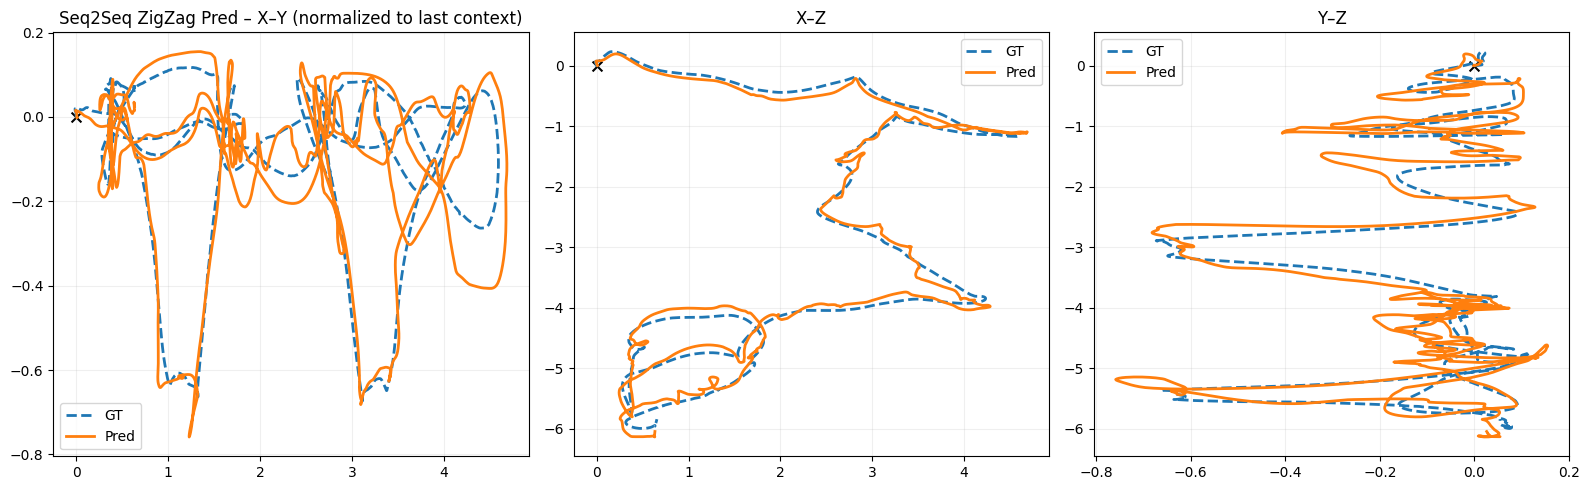

In [22]:
file_path= "/content/drive/MyDrive/Dance_clean_data/D1_All_CSVs/cleaned_Take 072817_Sub1_NewZigZag1 12.26.30 PM edit.npy"
arr=np.load(file_path).astype(np.float32)
pred,mask=predict_full_file_seq2seq(arr,model_all,mu,sig,seq_in=30,seq_out=30,step=1,device=DEVICE)
plot_3d(arr,pred,title="Seq2Seq ZigZag Pred",xyz_idx=(16,17,18),normalize_to_last_context=True,ctx_len=30)
plot_2d(arr,pred,title="Seq2Seq ZigZag Pred", xyz_idx=(16,17,18),normalize_to_last_context=True,ctx_len=30)

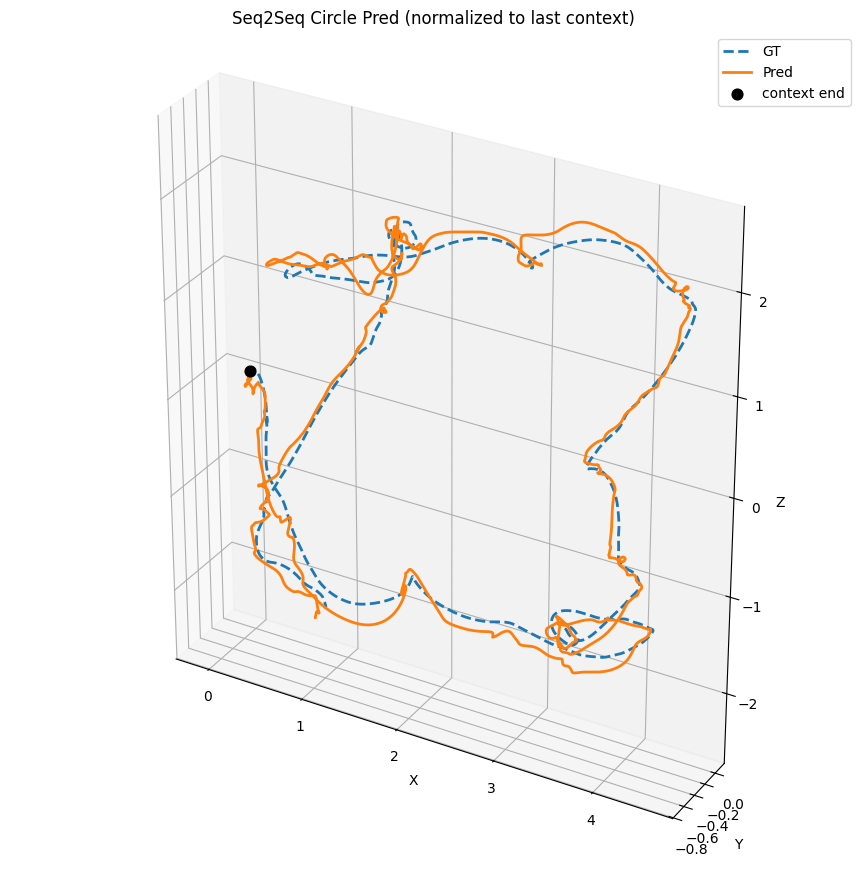

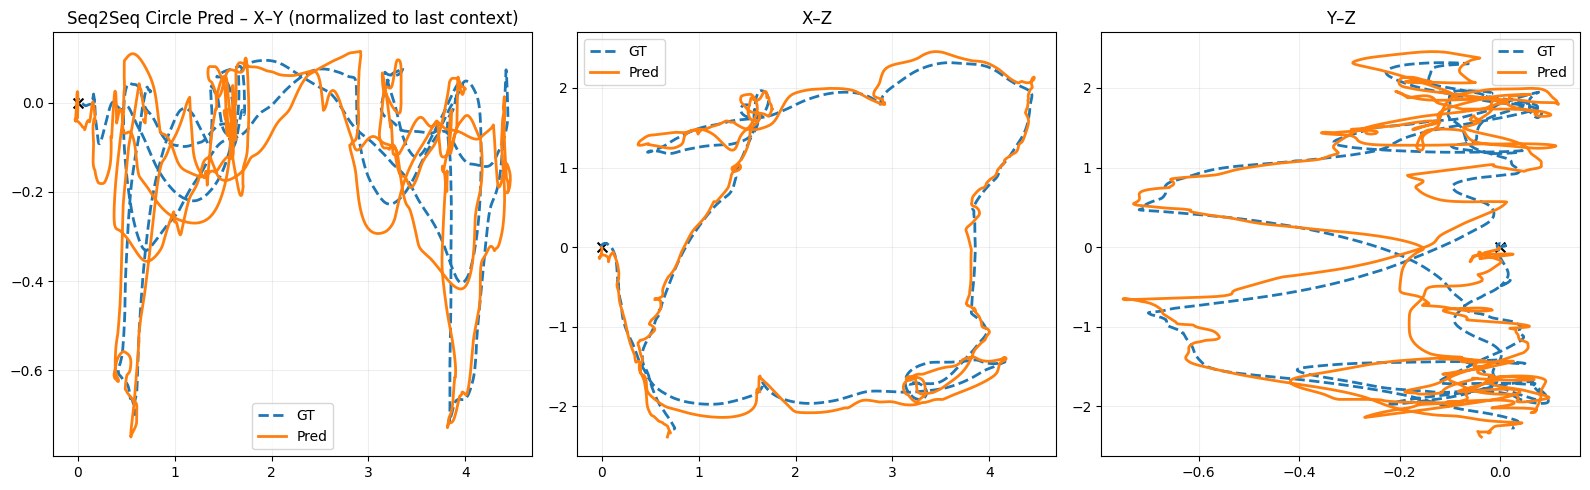

In [23]:
file_path="/content/drive/MyDrive/Dance_clean_data/D9_All_CSVs/cleaned_Take 091517_Sub10_Circle3 01.12.49 PM edit.npy"
arr=np.load(file_path).astype(np.float32)
pred,mask=predict_full_file_seq2seq(arr,model_all,mu,sig,seq_in=30,seq_out=30,step=1,device=DEVICE)
plot_3d(arr, pred,title="Seq2Seq Circle Pred",xyz_idx=(16,17,18),normalize_to_last_context=True, ctx_len=30)
plot_2d(arr,pred, title="Seq2Seq Circle Pred", xyz_idx=(16,17,18),normalize_to_last_context=True,ctx_len=30)